In [31]:
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network

# Connect to db collections
client = MongoClient('mongodb://localhost:27017/')
db = client['address-clustering']
transfers = db['transfers']
transactions = db['transactions']

# Read intra-set token transfers CSV
token_transfers = pd.read_csv('../data/intra_token_transfers.csv', index_col=[0])
token_transfers

,timeStamp,hash,from,to,contractAddress,value,nonce,tokenName,gasPrice,gasUsed,chainName,tokenType,tokenID
0,1662353592,0xb40ea5aa7be6a9bd40a401776a5cbcc79baec55abcd3...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85,NaN,262,Ethereum Name Service,11669714414,35891,Ethereum,721,9.195376e+75
1,1661006285,0x259b903f6c1ec513b9792768859cea2e429aed92375a...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x60ab31673485542e3ca55ba3a42c693863caff10,0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85,NaN,76,Ethereum Name Service,10898502261,525347,Ethereum,721,2.595492e+76
2,1661687584,0xf028f85d40cb7ad41a95c40f36772e4fcd1c6b5e6bf3...,0x00009dc8aac69accf38e87ab42a82a28be68f2a0,0x00009dc8aac69accf38e87ab42a82a28be68f2a0,0x8f3cf7ad23cd3cadbd9735aff958023239c6a063,0.11,61,(PoS) Dai Stablecoin,30000068397,32562,Polygon,20,NaN
3,1649007251,0x131db9db1de6204423552c97aedf437776e4c27101b9...,0x00009dc8aac69accf38e87ab42a82a28be68f2a0,0x03ba161f99e0561adc546644640ba6d5602d86c8,0x493a5bad290b6f5a750e180d48074f1de31aec47,NaN,7433,DAZZLE Fashion 2022 MVFW Catwalk,35150000000,271656,Polygon,721,1.300000e+01
4,1652940559,0x4fa9dea1bfef721568d7aa55140b1f7969344a44c0a7...,0x00009dc8aac69accf38e87ab42a82a28be68f2a0,0x0749d1abb5ca9128432b612644c0ea1e9c6cc9af,0xfdac3c4ffccb6e05d3e9a9d69ec95edeb6e8c844,NaN,31220,AO 2022 - Accessories,37064012768,272721,Polygon,721,5.265615e+65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
974473,1671413907,0xff4b2d8133986f6b6a9d6bbd88a2bfb1c5abee3648ea...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,0xb854bf4d15be8e1f9b38e8b6af7d3283b81edfd8,NaN,40309,ICE Poker SNG Wearables,61922750388,145726,Polygon,721,2.106246e+65
974474,1671413931,0x0635f1dcc46059bfb00d29130914370cbe4bb2c8061a...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,0xbcbdf467b5530d85b792d9e8afb109d7d1ac32c4,NaN,59757,FOMO Bro NFTee,64081415590,137287,Polygon,721,1.620000e+02
974475,1671413955,0xe4dde48b270b76854b461748dfc1c0f5fd0cc986a4ef...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,0x873c11f798fc6f6c370c40f460aae4e20069b105,NaN,96970,Roland Lifestyle DCLMVMF 2022,64737010321,162802,Polygon,721,7.320000e+02
974476,1652154158,0x085c04dacb55543e2333f84395b3ae93b8631c69d57f...,0xffffca7879d31e91047d37193a5b806f5f791848,0x16efdf4ef182a5b82221fed14f4c3996922d00e2,0xdac17f958d2ee523a2206206994597c13d831ec7,100.00,27,Tether USD,49354171902,46085,Ethereum,20,NaN


### Detect LAND transfer transactions

In [3]:
# Get all LAND transfer hashes
LAND_transfers = token_transfers[token_transfers['tokenName']=='Decentraland LAND']
LAND_hashes = LAND_transfers['hash'].to_list()

# Get all token transfers that occured within a LAND transfer
transfers_docs = pd.DataFrame(list(transfers.find({"hash": {"$in": LAND_hashes}})))

# Get all ether transfers where LAND was transferred at the same time
transactions_docs = pd.DataFrame(list(transactions.find({"hash": {"$in": LAND_hashes}})))
transactions_docs = transactions_docs[transactions_docs['value']!=0]
transactions_docs['tokenType'] = 'native'

# Drop columns for duplicate elimination
transfers_docs = transfers_docs.drop(['_id', 'isSet', 'userAddress'], axis=1)
transactions_docs = transactions_docs.drop(['_id'], axis=1)

# Concatenate both dataframes
df = pd.concat([transactions_docs, transfers_docs])
print(len(df))
df = df.drop_duplicates()
print(len(df))
df

13491
4951


,hash,from,to,timeStamp,nonce,value,gasPrice,input,gasUsed,functionName,chainName,tokenType,contractAddress,tokenName,tokenID
2,0x17571eea843c9fe6e63951b2bdc58dab72c0c8934ec9...,0x00b14e0d39b50cded16321b7302c4ad72cac3bc0,0x00000000000000adc04c56bf30ac9d3c0aaf14dc,1685941091,223.0,600000000000000000.0,21362754466,0x00000000000000000000000000000000000000000000...,228538,buyAndFree22457070633(uint256 amount),Ethereum,native,NaN,NaN,NaN
21,0xed1265482b15b819f7773d3e51a959d73a2a62f34ab2...,0x03e2c10b74a260f46ab5cf881938c5888a6142df,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,1639493637,724.0,4400000000000000000.0,53163721012,0xab834bab0000000000000000000000007be8076f4ea4...,224151,"atomicMatch_(address[14] addrs, uint256[18] ui...",Ethereum,native,NaN,NaN,NaN
44,0xb926f4a23e1796aade482be8bb77a189daad6f586e2c...,0x059d0025e4e1bb1a37f2c922e54b139bc1231ee0,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,1632509313,50.0,1299000000000000000.0,69133373448,0xab834bab0000000000000000000000007be8076f4ea4...,246199,"atomicMatch_(address[14] addrs, uint256[18] ui...",Ethereum,native,NaN,NaN,NaN
72,0x812ddf1d78713bf30d0da65e0456410cf99d4cb95f53...,0x092f390c7742e0aabb3e214028d956437b64a245,0x00000000000001ad428e4906ae43d8f9852d0dd6,1682426495,0.0,666000000000000000.0,34862022275,0x00000000000000000000000000000000000000000000...,228550,buyAndFree22457070633(uint256 amount),Ethereum,native,NaN,NaN,NaN
80,0xaca00e847589aa50dded593f96ec4d22d9db7d720442...,0x0b8e66e57da730838cc994f54984346803d0d299,0x00000000006c3852cbef3e08e8df289169ede581,1665069911,8.0,1700000000000000000.0,31785690143,0xfb0f3ee1000000000000000000000000000000000000...,218949,0xfb0f3ee1(),Ethereum,native,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8546,0xc14361a4f4827a1c7ddcca81c4e65f4eda7b79be624c...,0xf15d7066b78a4e969deefa1e4ca945212ddd3171,0xfabe9cb4fa6f0dfbf9088c9ec93304383383475d,1675114655,57.0,,17764320290,NaN,219157,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,1157920892373161954235709850086879078532699846...
8548,0x1d74a927f28816dd858277667d5cc9410d50c896925c...,0xf179344bbec75ad4522bd6b2c780b2e13b3469a2,0xf5fdaa91b9bcbbde2e3626e4c4c817b34bd796f9,1633061756,165.0,,76350609347,NaN,243534,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,12930729942995661611608235082407192035328.0
8550,0x3416328b9767cb0af3037da2587a81142691117742d4...,0xf8dbddf1a5da0b1ad72f7cf843829549e574b8be,0xf179344bbec75ad4522bd6b2c780b2e13b3469a2,1638446049,578.0,,98463938308,NaN,171581,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,1157920892373161954235709850086879078532699846...
8552,0xa8ad003575cfdb1e73cc1e8091219953286c58cc24ec...,0xf7114e709c7b979f37bb9a83acdb4567bf38902b,0xf179344bbec75ad4522bd6b2c780b2e13b3469a2,1662398740,1308.0,,9483665440,NaN,175872,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,1157920892373161954235709850086879078532699846...


### Detect purchases

In [4]:
# Create DataFrame with unique 'hash', 'from' and 'to' combinations
unique_df = df[['hash', 'from', 'to']].drop_duplicates()

# Group by 'hash' and check if any address appears in both 'from' and 'to' for each 'hash'
hash_groups = unique_df.groupby('hash')
purchase_dict = {}
for name, group in hash_groups:
    purchase_dict[name] = any(addr in group['from'].values for addr in group['to'].values)

# Create new 'purchase' column in original DataFrame based on the computed dictionary
df['purchase'] = df['hash'].map(purchase_dict)

land = df[df['tokenType']==721]
print(land.columns)

Index(['hash', 'from', 'to', 'timeStamp', 'nonce', 'value', 'gasPrice',
       'input', 'gasUsed', 'functionName', 'chainName', 'tokenType',
       'contractAddress', 'tokenName', 'tokenID', 'purchase'],
      dtype='object')
3805    True
3807    True
3809    True
3811    True
3813    True
Name: purchase, dtype: bool


### Remove purchases

In [32]:
transfers = df[df['purchase']==False]
transfers = transfers[transfers['tokenName']!='Decentraland Land Balance']
transfers

,hash,from,to,timeStamp,nonce,value,gasPrice,input,gasUsed,functionName,chainName,tokenType,contractAddress,tokenName,tokenID,purchase
480,0x30ed73a214c2aa234a540483c61b1f023530ca48b643...,0x98c1d8a5cd2e6fa559ba6ae0680b388b799ac231,0x1d4b9b250b1bd41daa35d94bf9204ec1b0494ee3,1616896550,565.0,3039.0,88000000000,NaN,809362,NaN,Ethereum,20,0xf5b0a3efb8e8e4c201e2a935f110eaaf3ffecb8d,Axie,,False
482,0x30ed73a214c2aa234a540483c61b1f023530ca48b643...,0x98c1d8a5cd2e6fa559ba6ae0680b388b799ac231,0x1d4b9b250b1bd41daa35d94bf9204ec1b0494ee3,1616896550,565.0,233369.0,88000000000,NaN,809362,NaN,Ethereum,20,0xf5b0a3efb8e8e4c201e2a935f110eaaf3ffecb8d,Axie,,False
558,0x19a1de24f10774cf1e4e726fc916af76825db8e01d86...,0x2245aa1cd81344413a970d7efd8d49ac738c3a7b,0x3ee7a2741442cf024ad185d6757aa830c8b31e9d,1673301047,54.0,5113.0,25951965485,NaN,419801,NaN,Ethereum,20,0x79986af15539de2db9a5086382daeda917a9cf0c,Cryptovoxels Parcel,,False
560,0x19a1de24f10774cf1e4e726fc916af76825db8e01d86...,0x2245aa1cd81344413a970d7efd8d49ac738c3a7b,0x3ee7a2741442cf024ad185d6757aa830c8b31e9d,1673301047,54.0,5109.0,25951965485,NaN,419801,NaN,Ethereum,20,0x79986af15539de2db9a5086382daeda917a9cf0c,Cryptovoxels Parcel,,False
2818,0x5e80859b780cf7dd1a5f45489aaea350311ba67b8e36...,0xd5a5a16f3dcae1b9fb55f94c8780bbbe8ef72f4a,0x986740c15007053c43702f69dc95b0e114ad7f30,1666513763,36.0,6922.0,11889825899,NaN,313697,NaN,Ethereum,20,0x79986af15539de2db9a5086382daeda917a9cf0c,Cryptovoxels Parcel,,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8500,0xae9e32ed4c47b4115950e5b61b5937f7a974b534a1c9...,0xffac7fd045303112fdb28e9dace8e1334ad324c0,0xe7f78d2c9a9375153476834d2db32632384b01e1,1674101279,148.0,,17355256351,NaN,112602,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,43215860598959184859848575143834562854912.0,False
8502,0x02f79dc540fab903673cdc4613c578e0123b549e9570...,0xffac7fd045303112fdb28e9dace8e1334ad324c0,0xe7f78d2c9a9375153476834d2db32632384b01e1,1674101291,149.0,,18215383660,NaN,106123,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,25861459885991323223216470164814384070656.0,False
8522,0x4f92a58ac04f125d97e51c7dd2315b4f9a2027663a9c...,0xf6852df0c0a18ac3a4cb4b5d470895f86d3861ce,0xed498e75d471c3b874461a87bb7146453cc8175a,1536176413,102.0,,5000000000,NaN,111027,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,1157920892373161954235709850086879078532699846...,False
8524,0x07ad3adbf17ab13fc0b37d4971d4b35f862c8c4ec437...,0xf6852df0c0a18ac3a4cb4b5d470895f86d3861ce,0xed498e75d471c3b874461a87bb7146453cc8175a,1536176441,103.0,,5000000000,NaN,111027,NaN,Ethereum,721,0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d,Decentraland LAND,1157920892373161954235709850086879078532699846...,False


### Build clusters

In [21]:
# Create graph
G = nx.from_pandas_edgelist(transfers, 'from', 'to', create_using=nx.Graph())

# Find connected components (clusters)
clusters = list(nx.connected_components(G))

# Create a DataFrame to store the cluster ID, addresses, and cluster size
cluster_df = pd.DataFrame(columns=['ClusterID', 'Address', 'ClusterSize'])

# Fill the DataFrame with the cluster ID, corresponding addresses, and cluster size
cluster_id = 0
for cluster in clusters:
    cluster_size = len(cluster)
    for address in cluster:
        cluster_df = cluster_df.append({
            'ClusterID': cluster_id,
            'Address': address,
            'ClusterSize': cluster_size
        }, ignore_index=True)
    cluster_id += 1

cluster_df

,ClusterID,Address,ClusterSize
0,0,0x98c1d8a5cd2e6fa559ba6ae0680b388b799ac231,2
1,0,0x1d4b9b250b1bd41daa35d94bf9204ec1b0494ee3,2
2,1,0x3ee7a2741442cf024ad185d6757aa830c8b31e9d,2
3,1,0x2245aa1cd81344413a970d7efd8d49ac738c3a7b,2
4,2,0xd5a5a16f3dcae1b9fb55f94c8780bbbe8ef72f4a,2
...,...,...,...
408,159,0xd42ce5ab59007b2b8de420d1c9712c32ae93bc0f,2
409,160,0xd83682d4818d6d044ce613a19f605c2af7ab6729,2
410,160,0xdb1ac1d3cacf1bb80e3597bb0ee3caf52d266dfa,2
411,161,0xdb0db8a93eecafd73da99cf851e63feda43f35b7,2


### Visualize transfers

In [33]:
nt = Network(notebook=True)
nt.from_nx(G)

nt.show("../figures/network_graph.html")

../figures/network_graph.html


### Visualize token network

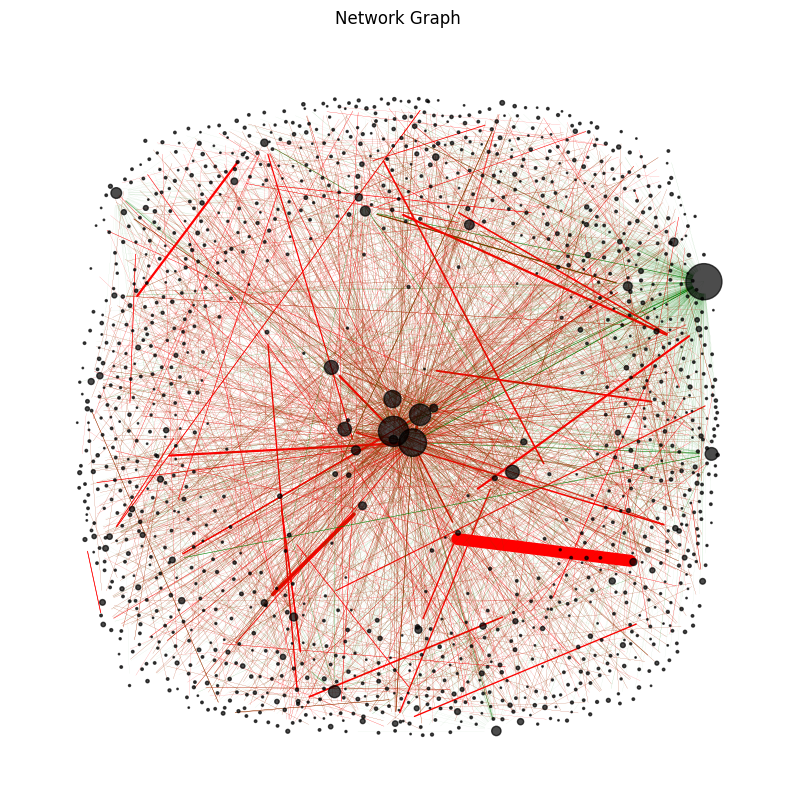

In [16]:
# Group the data by 'from','to','tokenType' and calculate the size of each group
grouped_df = df.groupby(['from','to','tokenType']).size().reset_index(name='weight')

# Create the graph using 'weight' as the edge attribute
G = nx.from_pandas_edgelist(grouped_df, source='from', target='to', edge_attr=True, create_using=nx.DiGraph())

plt.figure(figsize=(10, 10))


# Create a color map for the edges
colors = ['red' if G[u][v]['tokenType']==721 else 'green' for u, v in G.edges()]

# Create a list of edge widths based on the 'weight' attribute (you may need to adjust the scaling factor)
widths = [G[u][v]['weight'] / 50.0 for u, v in G.edges()]

# Create a layout for the nodes
layout = nx.spring_layout(G, k=0.5, iterations=10)

# Calculate degrees of each node and create a list of node sizes
degrees = [G.degree(n) for n in G.nodes()]
node_sizes = [d * 1.1 for d in degrees]

# Draw the edges with colors and widths based on the edge attributes
nx.draw_networkx_edges(G, pos=layout, edge_color=colors, width=widths, arrowstyle="-")

# Draw the nodes
nx.draw_networkx_nodes(G, pos=layout, node_size=node_sizes, node_color='black', alpha=0.7)

plt.title('Network Graph')
plt.axis('off')
plt.show()

In [38]:
# Create graph
G = nx.from_pandas_edgelist(land, source='from', target='to', edge_attr='purchase', create_using=nx.DiGraph())

# Create a Pyvis Network
nt = Network(notebook=True)

# Iterate over edges to set colors
for u, v, data in G.edges(data=True):
    if data['purchase'] == True:
        G[u][v]['color'] = 'red'
    else:
        G[u][v]['color'] = 'green'

# Import the NetworkX graph into Pyvis
nt.from_nx(G)

# Customize and show
nt.toggle_hide_edges_on_drag(True)
nt.set_edge_smooth('dynamic')
nt.set_template('inline')
nt.show("temp.html")

temp.html
